In [26]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import plotly.express as px
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, KFold
import yaml
import logging
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt


# 1. Load Data

In [16]:
df = pd.read_csv('../data/Cancer_Data.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


# 2. Preprocessing

In [12]:
pd.set_option('display.max_rows', 500)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [13]:
df['diagnosis'].value_counts()

diagnosis
B    357
M    212
Name: count, dtype: int64

In [17]:
df = df.drop(['Unnamed: 32', 'id'], axis=1)
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


# 3. Model Trainig

In [29]:
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.values.reshape(-1, X.shape[-1]))

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [10, 50, 100, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

rf = RandomForestClassifier(n_estimators=100, random_state=42)
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=50, cv=2, verbose=1, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_

best_score, best_params

best_model = random_search.best_estimator_




Fitting 2 folds for each of 50 candidates, totalling 100 fits


# 4. Tree Visualization

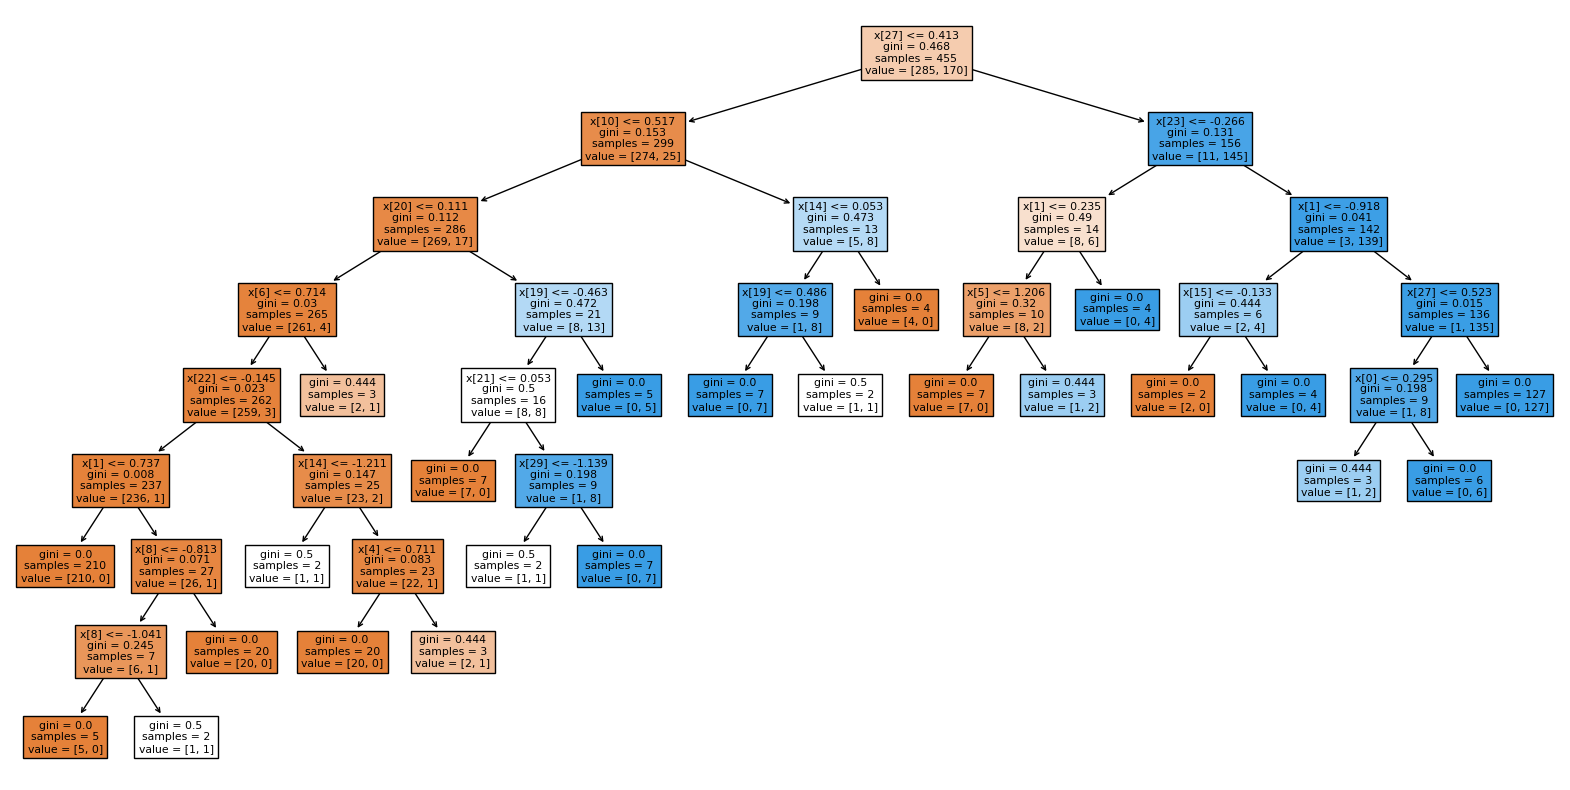

In [30]:
plt.figure(figsize=(20, 10))
plot_tree(best_model.estimators_[0], filled=True)
plt.show()

# 5. Feature Importance

In [32]:
feature_importances = best_model.feature_importances_
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': feature_importances})


,feature,importance
0,radius_mean,0.065515
1,texture_mean,0.012852
2,perimeter_mean,0.062800
3,area_mean,0.066589
4,smoothness_mean,0.006580
5,compactness_mean,0.011411
6,concavity_mean,0.045566
7,concave points_mean,0.076880
8,symmetry_mean,0.003594
9,fractal_dimension_mean,0.001668


# 6. Confusion Matrix & Classification Report

In [35]:
# Confusion Matrix and Classification Report

y_pred = best_model.predict(X_test)
confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.96      1.00      0.98        72
           1       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114

